# Outflows from a piece of the galactic disk

## Hydrodynamics
The equations of hydrodynamics are
\begin{align}
\partial_t \rho + \mathbf{\nabla} \cdot [\rho\,\mathbf{v}] & = 0 \\
\partial_t \rho\,\mathbf{v} + \mathbf{\nabla} \cdot [\rho\, \mathbf{v}\otimes\mathbf{v} + P \mathsf{I}] & = \rho\, \mathbf{g} \\
\partial_t E + \mathbf{\nabla} \cdot [(E + P)\, \mathbf{v}] & = \rho\, \mathbf{v} \cdot \mathbf{g} \,,
\end{align}
where $\rho$ is density, $\mathbf{v}$ is velocity, $P$ is pressure, and $E$ is the total energy density, and $\mathbf{g}$ is the gravitational acceleration from an external gravitational field. $E = \rho e + {1 \over 2} \rho v^2$, and $e$ is the internal energy per mass. This is complemented by an equation of state $P = (\gamma - 1)\rho e$.

This can also be written in the Lagranian form
\begin{align}
\partial_t \rho & = - \mathbf{v} \cdot \mathbf{\nabla} \rho
- \rho \mathbf{\nabla} \cdot \mathbf{v} \\
\partial_t \mathbf{v} & = - (\mathbf{v} \cdot \mathbf{\nabla}) \mathbf{v}
- \frac{1}{\rho} \mathbf{\nabla} P + \mathbf{g} \\
\partial_t P &= - \mathbf{v} \cdot \mathbf{\nabla} P
- \gamma P \mathbf{\nabla} \cdot \mathbf{v}\,,
\end{align}
where the advective derivative ($-\mathbf{v} \cdot \mathbf{\nabla}$) is explicit.

### Standard libaries

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
np.seterr(all='raise',under='ignore'); # this option makes the code crash if encountering divide-by-zero, overflow or other floating point errors, but ignores underflow

## Using a Python class to store things
We start by defining a class `hd`, with things we will need for 2-D hydrodynamics.

In [44]:
class void():
    """ Empty class, used to create ad hoc objects """
    pass

class hd():
    """ Template class for hydrodynamics, with parameters, variables and methods """
    def __init__(self,n=64,gamma=1.4,Lbox=1.):
        """ Initialization of arrays for conservative variables """
        self.t=0
        self.n=n
        self.gamma = gamma
        self.rho   = np.ones((n,n))
        self.Etot  = np.ones((n,n))
        self.Px    = np.zeros((n,n)) #momentum in x
        self.Py    = np.zeros((n,n)) #momentum in y
        self.coordinates(Lbox=Lbox)
    
    def coordinates(self,Lbox=1.):
        """ Coordinate initialization """
        n = self.n
        self.ds = Lbox/n
        self.dx = self.ds
        self.Lbox = n*self.ds # Make sure n, ds, and Lbox correspond exactly to roundoff
        self.x = self.ds*(np.arange(n)-n/2+0.5)
        self.y = np.copy(self.x)
        self.r = np.zeros((n,n))
        for i in range(n):
            self.r[i] = (self.y**2 + self.x[i]**2)**0.5

    def velocity(self):
        """ Compute velocity from conservative variables and return in (2,n,n) array """
        return np.array([self.Px/self.rho, self.Py/self.rho])

    def pressure(self):
        """ Compute pressure from conservative variables """
        if (self.gamma==1.0):
            P = self.cs**2 * self.rho
        else:
            Eint = self.Etot - 0.5*(self.Px**2 + self.Py**2)/self.rho 
            P = (self.gamma-1.)*Eint
        return P

    def temperature(self):
        """ Compute the 'temperature', defined as P/rho = kB / mu T """
        return self.pressure() / self.rho
    
    def Courant(self,C=0.5):
        """ Courant condition for HD """
        v = self.velocity()
        speed = np.sqrt(v[0]**2 + v[1]**2)
        cs = np.sqrt(self.gamma*self.pressure()/self.rho)
        return C*self.ds/np.max(cs+speed)

## Riemann Solvers

Riemann solvers are used to compute the fluxes that pass mass, momentum, and energy from cell to cell.  When working in two dimensions, we need to treat the interfaces on all four sides of each cell, with differences between _left_ and _right_, and _bottom_ and _top_ controlling the changes of conserved quantities.

### HLL (Harten, Lax, van Leer) fluxes

In [45]:
# Conservative variables computed from primitve variable
def primitive_to_conservative(q):
    U = void()
    U.D  = q.D
    U.mU = q.D*q.U
    U.mV = q.D*q.V
    U.Etot = q.P / (q.gamma-1.0) + 0.5*q.D*(q.U**2 + q.V**2)
    return U

# Hydro flux from conservative and primitive variables
def Hydro_Flux(q,U):
    F = void()
    F.D = U.mU
    F.mU = U.mU*q.U + q.P
    F.mV = U.mV*q.U
    F.Etot = q.U*(U.Etot + q.P)
    return F

def HLL(ql,qr):
    # The first part is the same as for LLF, so just use copy & paste to fill that in:
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)

    # maximum wave speeds to the left and right (guaranteed to have correct sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.
    
    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)

    # HLL flux based on wavespeeds.  The general form is 
    #    (SR*F_left - SL*F_right + SL*SR *(u_right - u_left))/(SR-SL)
    # where U = (rho, rho*v, E_tot) are the conserved variables
    Flux = void()
    Flux.D  = (SR*Fl.D  - SL*Fr.D  + SL*SR*(Ur.D  - Ul.D )) / (SR - SL)
    Flux.mU = (SR*Fl.mU - SL*Fr.mU + SL*SR*(Ur.mU - Ul.mU)) / (SR - SL)
    Flux.mV = (SR*Fl.mV - SL*Fr.mV + SL*SR*(Ur.mV - Ul.mV)) / (SR - SL)
    Flux.Etot = (SR*Fl.Etot - SL*Fr.Etot + SL*SR*(Ur.Etot - Ul.Etot)) / (SR - SL)

    return Flux

### Slope limiter
Monotonized Central (MonCen) slope limiter.  In two dimensions, return the  slopes in both directions, with shape (2,n,n)

In [46]:
def left_slope(f,axis=0):
    return (f-np.roll(f,1,axis))

def MonCen(f):
    """ Monotonized central slope limiter """
    shape=np.insert(f.shape,0,f.ndim)
    slopes=np.zeros(shape)
    for i in range(f.ndim):
        ls=left_slope(f,axis=i)
        rs=np.roll(ls,-1,axis=i)
        cs=np.zeros(f.shape)
        w=np.where(ls*rs>0.0)
        cs[w]=2.0*ls[w]*rs[w]/(ls[w]+rs[w])
        slopes[i]=cs
    return slopes

### MUSCL method
This is the core routine for solving hydrodynamics in one timestep. In the routine we have six steps:
  * 0) + 7) (operator split) source term for external gravitational potential add before and after the hydro fluxes to make it second order
  * 1) Primitive variables from conserved variables
  * 2) Slopes used for interpolation from cell center to cell interface and for time prediction
  * 3) Forward trace in time to find solution at t + dt/2
  * 4) + 5) Construction of "Left" and "Right" states for the cell interfaces
  * 6) Call to Riemann solver (HLL) to compute the fluxes for hydrodynamics and update of conserved variables

In [47]:
def Source_cooling(u):
    """ Add cooling / heating here """
    # compute temperature in physical units using mu=0.615

def Source(u):
    """ Add contribution from gravitation with 1/2*dt
        The gravitaitonal acceleration is time independent
        and stored in the variable u.g.
        S(E_tot) = rho vy * g
        S(rho vy) = rho g
    """
    u.Etot += 0.5*u.dtds*u.Py*u.g
    u.Py   += 0.5*u.dtds*u.rho*u.g

def muscl_2d (u, dt, do_grav=True, do_cooling=False):
    u.dtds = dt/u.ds
    u.dt = dt
    Slope=MonCen
    Riemann_Solver=HLL

    # 0) Add gravity 
    if do_grav:
        Source(u)                          # Add 1/2 source term at time t
    
    # 1) Compute primitive variables (rho, v, P)
    # make sure to copy u.rho to D, otherwise D becomes a "pointer" to u.rho, and updates itself in 5)
    D = np.copy(u.rho)         # D: density
    v = u.velocity()           # v: velocity
    P = u.pressure()           # P: pressure

    # 2) Compute slopes based on centered points
    dD = Slope(D)              # returns (2,n,n)
    dP = Slope(P)              # returns (2,n,n)
    dv0 = Slope(v[0])          # returns (2,n,n)
    dv1 = Slope(v[1])          # returns (2,n,n)
    dv = np.array([dv0,dv1])   # shape = (2,2,n,n)

    # 3) Trace forward to find solution at [t+dt/2, x +- dx/2]
    # Time evolution with source terms
    div = dv[0,0] + dv[1,1]                  # div(v)
    D_t = - v[0]*dD[0] -v[1]*dD[1] - D*div   # dD/dt = -v*grad(D) - D*div(v)
    P_t = - v[0]*dP[0] -v[1]*dP[1] - u.gamma*P*div   # dP/dt = -v*grad(P) - gamma*P*div(v)
    v_t = np.copy(v)                         # shape = (2,n,n)
    v_t[0] = - v[0]*dv[0,0] - v[1]*dv[0,1] - dP[0]/D  # dv/dt = -v*grad(v) - grad(P)/D
    v_t[1] = - v[0]*dv[1,0] - v[1]*dv[1,1] - dP[1]/D
    if do_grav:
        v_t[1] += u.g*u.ds # have to add ds because slopes are differences without ds
    
    # Loop over X- and Y-direction
    for axis in range(2):
        ql = void(); ql.gamma = u.gamma
        qr = void(); qr.gamma = u.gamma
        
        # Calculates the parallel and perpendicular velocities to the coordinate direction
        # X-axis: iu=0, iv=1, Y-axis: iu=1, iv=0
        iu = axis
        iv = (axis + 1) % 2
        # Parallel (U) and perpendicular (V) velocities
        U = v[iu]; dU = dv[iu]; U_t = v_t[iu]
        V = v[iv]; dV = dv[iv]; V_t = v_t[iv]

        # 4) Spatial interpolation "axis"-direction + time terms

        # left state -- AS SEEN FROM THE INTERFACE
        ql.D = D + 0.5*dD[axis] + 0.5*u.dtds*D_t
        ql.P = P + 0.5*dP[axis] + 0.5*u.dtds*P_t
        ql.U = U + 0.5*dU[axis] + 0.5*u.dtds*U_t
        ql.V = V + 0.5*dV[axis] + 0.5*u.dtds*V_t

        # right state -- AS SEEN FROM THE INTERFACE
        qr.D = D - 0.5*dD[axis] + 0.5*u.dtds*D_t
        qr.P = P - 0.5*dP[axis] + 0.5*u.dtds*P_t
        qr.U = U - 0.5*dU[axis] + 0.5*u.dtds*U_t
        qr.V = V - 0.5*dV[axis] + 0.5*u.dtds*V_t

        # 5) Roll down -1 in the "axis" direction so that we collect
        #    left and right state (as seen from the interface) at the same grid index
        qr.D = np.roll(qr.D,-1,axis=axis)
        qr.P = np.roll(qr.P,-1,axis=axis)
        qr.U = np.roll(qr.U,-1,axis=axis)
        qr.V = np.roll(qr.V,-1,axis=axis)

        # 6) Solve for flux based on interface values
        Flux = Riemann_Solver(ql,qr)

        # Update conserved variables with fluxes
        u.rho  -= u.dtds * (Flux.D - np.roll(Flux.D,1,axis=axis))
        u.Etot -= u.dtds * (Flux.Etot - np.roll(Flux.Etot,1,axis=axis))
        if axis==0: # X-axis
            u.Px   -= u.dtds * (Flux.mU - np.roll(Flux.mU,1,axis=axis))
            u.Py   -= u.dtds * (Flux.mV - np.roll(Flux.mV,1,axis=axis))
        if axis==1: # Y-axis
            u.Px   -= u.dtds * (Flux.mV - np.roll(Flux.mV,1,axis=axis))
            u.Py   -= u.dtds * (Flux.mU - np.roll(Flux.mU,1,axis=axis))

    # 7) Add gravity 
    if do_grav:
        Source(u)                          # Add 1/2 source term at t + dt
    
    # 8) Here you could add cooling and heating. Since cooling can be
    # stiff -- e.g. immediately forcing the gas to a certain
    # temperature -- it is best to do the full heating / cooling contribution
    # at the end of a timestep
    
    if do_cooling:
        Source_cooling(u)
    
    return u

# Model setup: a piece of a galactic disk

The physical setup is a 2 kpc piece of the galactic disk. We assume that initially the gas is in hydrostatic equilibrium and has an isothermal temperature of $T=10^3$ K. The initial condition can then be specified once we know the gravitational acceleration.

### Gravitational Potential
For simplicity, we assume that the gravitational acceleration is prescribed, and due to the Dark Matter halo, described by a NFW profile
\begin{equation}\tag{1}
\rho(R) = \frac{\rho_0}{{R\over R_s}\left(1 + {R \over R_s}\right)^2}
\end{equation}
Assuming that $z \ll R$ this leads to a vertical gravitational acceleration of:
\begin{equation}\tag{2}
g(z) = - \frac{G M_\textrm{vir}}{\ln(1+c) - {c \over 1+c}} \frac{\ln(1 + R / R_s) - R / ( R + R_s )}{R^2} \frac{z}{R}\,,
\end{equation}
where $g(z)$ is the vertical acceleration, $M_\textrm{vir}$ is the virial mass of the galaxy, $c = R_\textrm{vir} / R_s$ is the concentration parameter, $R_s$ the inner radius for the NFW profile, and $R$ is the radius of the piece of the galactic disk. Collecting constant factors, this can be simplified to the relation
\begin{equation}\tag{3}
g(z) = - \Omega^2 z \,,\quad \Omega^2 = \frac{G M_\textrm{vir}}{\ln(1+c) - {c \over 1+c}} \frac{\ln(1 + R / R_s) - R / ( R + R_s )}{R^3}\,,
\end{equation}
where we see that $\Omega$ is the rotation frequency at radius $R$.

### Virial Mass and Radius
The concentration parameter (and hence $R_s$) is related to the virial mass as \[Posti \& Helmi 2019\]:
\begin{equation}\tag{4}
\log_{10} c = 1.025 - 0.097 \log_{10} \left(\frac{M_\textrm{vir}}{10^{12} h^{-1} M_\odot}\right)\,,
\end{equation}
where $h=0.68$ is the Hubble parameter in units of 100 km s$^{-1}$ Mpc$^{-1}$. We use the common assumption that $\rho_\textrm{vir} = 200 \,\rho_\textrm{crit}$ is a good approximation for the virial density, where $\rho_\textrm{crit} = 3 H^2 / 8 \pi G = 1.878\,10^{-29} h^2$ g cm$^{-3} = 2.77\,10^{-7} h^2$ M$_\odot$ pc$^{-3}$ is the critical cosmological density. This allow us to derive the virial radius $R_\textrm{vir}$ from the virial mass of the galaxy by integrating eq (1) and using the relations between $c$, $R_s$, and $R_\textrm{vir}$ yielding
\begin{equation}
\rho_\textrm{vir} = 200 \rho_\textrm{crit} = \frac{\rho_0}{c(1+c)^2}
\end{equation}
\begin{equation}
M_\textrm{vir} = 4 \pi \int^{R_\textrm{vir}}_0 R^2 dR \rho(R) = 4 \pi \rho_0 c^{-3}\left[ \ln(1+c) - \frac{c}{c+1} \right] R_\textrm{vir}^3
\end{equation}


### Hydrostatic Equilibrium
The assumption of hydrostatic equilibrium in the vertical direction allow us to derive a pressure profile using
\begin{equation}
\frac{dP}{dz} = - \rho g(z) = - \rho \Omega^2 z 
\end{equation}
Adopting initially a constant temperature we have $P = c_s^2 \rho$, with the isothermal sound speed $c_s^2 = k_B T / \mu m_p$. This allow us to solve for the density as a function of height
\begin{equation}
\rho(z) = \frac{\Sigma}{\sqrt{2\pi} H_g}\exp\left[-{1\over 2}\left(\frac{z}{H_g}\right)^2\right]\,,
\end{equation}
where $H_g = c_s\, /\, \Omega$ is the scale height in the disk, and $\Sigma = \int dz\, \rho(z)$ is the surface density.

### Units
The natural units for the problem are
* Unit of mass: u_m = 1 solar mass
* Unit of length: u_l = 1 parsec
* Unit of time: u_t = 1 Myr

The relevant derived units are:
* Unit of velocity u_v = 1 pc / 1 Myr = 0.977813106 km/s
* Unit of density u_d = (solar mass / pc^3) = 6.7702543e-23 g / (cm^3) = 40.4768962 proton mass cm^-3
* Energy density u_e = u_m / u_l^3 * (u_l / u_t)^2 = 6.47316519e-13 barye (cgs beware)
* Energy u_E = u_m (u_l / u_t)^2 = 1.90181525e36 J

### Initial conditions

In [49]:
def initial_condition(Lbox=2000, n=128, R0 = 8000, sigma_gas=100, Mvir=1.3e12, h=0.68):
    # Lbox is the box size in pc
    # n is the numerical resolution in grid poins
    # R0 is the radial distance from the center of the galaxy of the box in parsec
    # sigma_gas is in units of M_sun / pc^2
    # Mvir is the virial mass in the galaxy. 1.3 10^12 Msun is relevant for the Milky Way
    # h is the Hubble constant in units of 100 km s^-1 Mpc^-1
    
    # Basic unit system is u_M = Msun, u_l = 1 pc, u_t = 1 Myr
    kms_to_uv = 0.977813106 # (pc/Myr) / (km/s)
    
    # concentration parameter and virial radius
    c = 10**(1.025 - 0.097*np.log10(Mvir * h / 1e12))
    rho_crit = 2.7744948e-7 * h**2         # M_sun pc^-3
    rho0 = 200. * rho_crit * c * (1+c)**2 # M_sun pc^-3
    Rvir = (Mvir*c**3 / (4*np.pi*rho0*(np.log(1+c) - c / (1+c))))**(1/3) # pc
    Rs   = Rvir / c
    
    # rotation frequency [Myr^-1]
    Gnewt = 4.49830999e-3 # Newtons constant of gravity in [pc^3 Msun^-1 Myr^-2] 
    Omega = np.sqrt( Gnewt * Mvir / (np.log(1+c) - c / (1+c)) * (np.log(1 + R0/Rs) - R0 / (R0 + Rs)) / R0**3 )
    
    # setup initial grid
    u = hd(n=n, gamma=5/3, Lbox=Lbox)
    
    # compute new density and energy profile
    Tini = 1e3
    cs = 11.585 * np.sqrt( Tini / 1e4 ) * kms_to_uv # sound speed [pc/Myr] for a fully ionized medium with mu = 0.615
    Hgas = cs / Omega
    
    u.g = np.zeros((n,n)) # array holding gravitational acceleration
    
    for iy,y in enumerate(u.y):
        u.rho[:,iy] = sigma_gas / (np.sqrt(2.*np.pi) * Hgas) * np.exp(-0.5 * (y / Hgas)**2) 
        u.g[:,iy] = - Omega**2 * y
        
    P = u.rho * cs**2
    u.Etot = P / (u.gamma - 1)
    
    u.Mvir = Mvir
    u.Rvir = Rvir
    u.rho0 = rho0
    u.c = c
    u.cs = cs
    u.Hgas = Hgas
    u.Omega = Omega
    
    return u

### Testing the initial conditions

In [50]:
def imshow(f,size=10,x=None):
    plt.figure(figsize=(size,size))
    if x == None:
        plt.imshow(np.transpose(f),origin='lower')
    else:
        plt.imshow(np.transpose(f),origin='lower',extent=[-x,x,-x,x])
    plt.colorbar();

Central density: 0.037781560488512805
Scale height  : 125.94980611630628
1 / Omega     : 35.15973646241477
Virial radius : 129683.32734664268
Concentration parameter : 10.719983830625154
Mass in box [Msun] 3124999.999999994


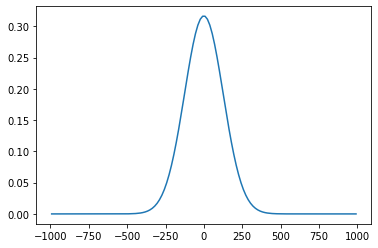

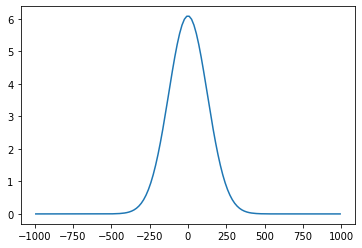

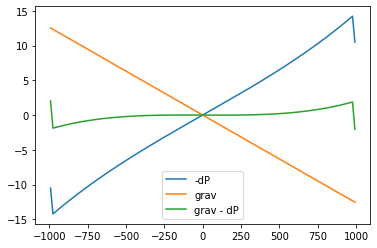

In [51]:
u = initial_condition(n=128)
print("Central density:", u.rho0)
print("Scale height  :", u.Hgas)
print("1 / Omega     :", 1. / u.Omega)
print("Virial radius :", u.Rvir)
print("Concentration parameter :", u.c)
print("Mass in box [Msun]", np.sum(u.rho)*u.ds**3)
plt.figure()
plt.plot(u.y,u.rho[0])
plt.show()
plt.figure()
plt.plot(u.y,u.Etot[0])
plt.show()
plt.figure()
P = (u.pressure())[0]
dPdy = 0.5*(np.roll(P,-1) - np.roll(P,+1))/u.ds
plt.plot(u.y,-dPdy/u.rho[0]*u.ds,label='-dP')
plt.plot(u.y,u.g[0]*u.ds,label='grav')
plt.plot(u.y,(u.g[0] - dPdy/u.rho[0])*u.ds,label='grav - dP')
plt.legend();


In [52]:
u.

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Blast wave function

### Here we add the blastwave with the following shape

\begin{equation}\tag{5}
f(r) = 1 + A \,\left(\frac{3}{w}\right)^2 e^{-\left(\frac{r}{w\Delta r}\right)^p}
\end{equation}

In [53]:
#doing this as a class instead of a function, or maybe not
def blast_wave(u,gamma=1.4,e0=1e3,d0=1.0,power=2,w=3.,eps=0.01):
#         n=u.n
        factor = (3./w)**2
        u.rho  += d0*factor*np.exp(-(u.r/(w*u.ds))**power)
        u.Etot = 1.0 + e0*factor*np.exp(-(u.r/(w*u.ds))**power)

12.1 sec, 0.74 microseconds/update
t=1.6900893284743108 nt=1000


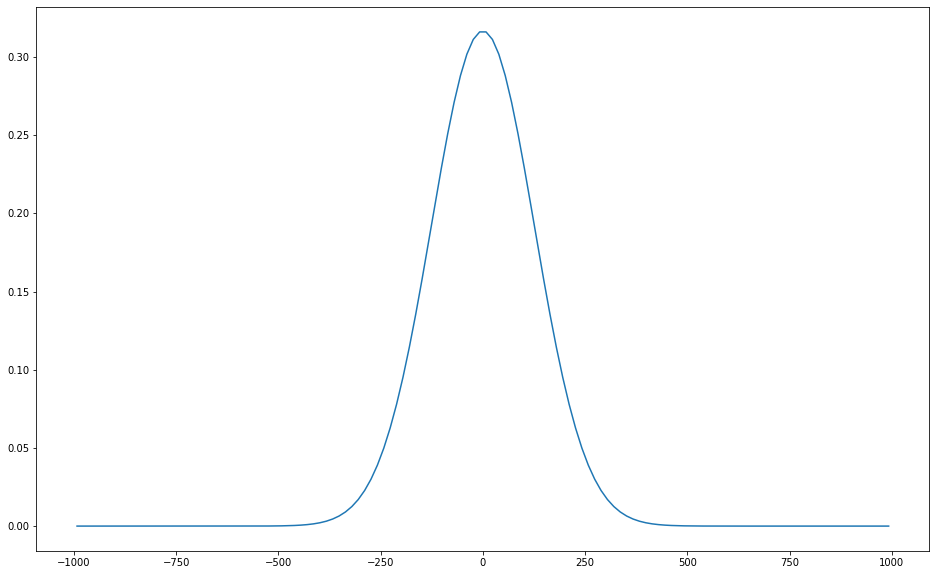

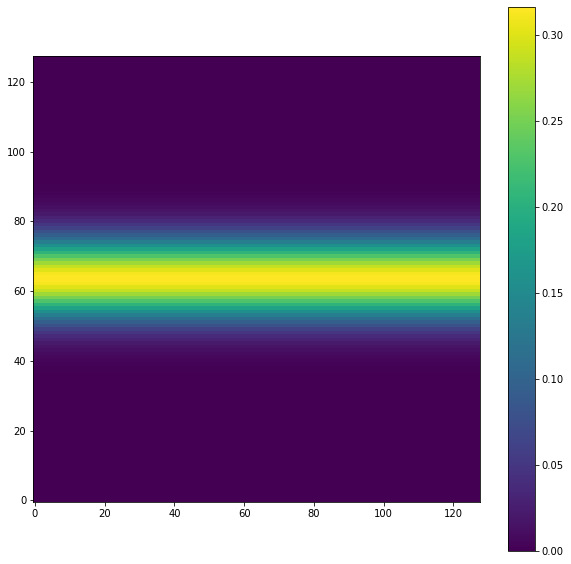

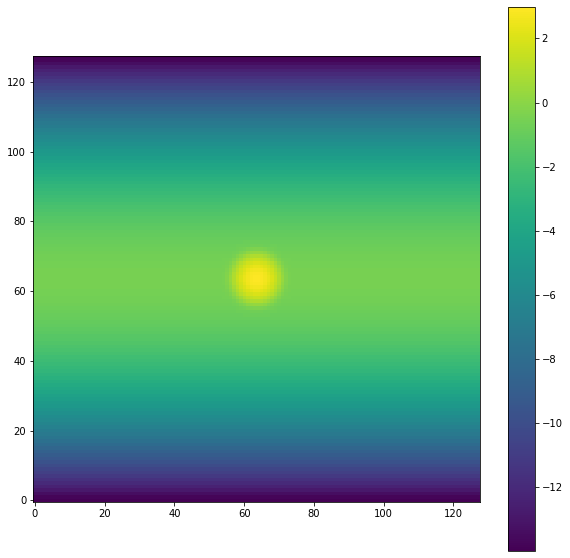

In [56]:
Lbox = 2e3
n = 128
Cdt = 0.5
nt = 1000
u = initial_condition(n=n, Lbox=Lbox)
u.rho_out = u.rho[0,0]
u.P_out = (u.pressure())[0,0]
start = time()
it=0
plt.figure(figsize=(16,10))
plt.plot(u.y,u.rho[0],label='rho0')
dt_plot = 1.0
t_plot = 0.
dt_SN = 0.2
t_SN = 0.
while u.t < 10 and it < nt:
    dt=u.Courant(Cdt)
    u = muscl_2d(u,dt)
    # Boundary conditions at upper and lower end of box:
    u.rho[:,0] = u.rho[:,-1] = u.rho_out
    u.Px[:,0] = u.Px[:,-1] = 0.
    u.Py[:,0] = u.Py[:,-1] = 0.
    u.Etot[:,0] = u.Etot[:,-1] = u.P_out / (u.gamma - 1.)
    u.t += dt
    it+=1
    #plt.figure()
    if (u.t - t_plot > dt_plot):
        #plt.plot(u.y,np.mean(u.Py,axis=0),label='t = {}'.format(u.t))
        #plt.plot(u.y,np.mean(u.rho,axis=0),label='')
        imshow(u.rho)
#         print("t={} P={} M={}".format(u.t,np.sum(u.pressure())),np.sum(u.rho)*u.ds**3)
        t_plot += dt_plot
    if (u.t - t_SN > dt_SN or True):
        blast_wave(u,e0=1e4,d0=1,power=2,w=3.)
        t_SN += dt_SN

#plt.legend()
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*it)))
print("t={} nt={}".format(u.t,it))
imshow(np.log10(u.rho))

In [37]:
np.min(u.pressure())

-3.7005005394694312

In [40]:
np.min(u.Etot - 0.5*(u.Px**2 + u.Py**2)/u.rho )

-5.550750809204146

In [42]:
np.max(u.rho)

1.9459594689067654

In [ ]:
np.shape(u.rho)

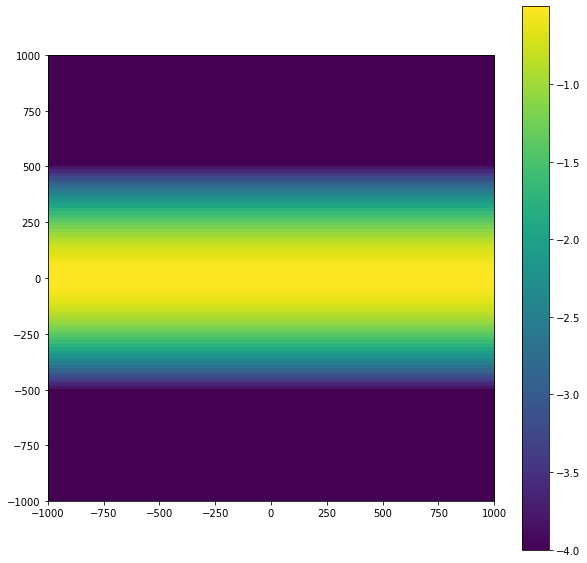

In [13]:
imshow(np.maximum(np.log10(u.rho),-4),x=u.Lbox*0.5)

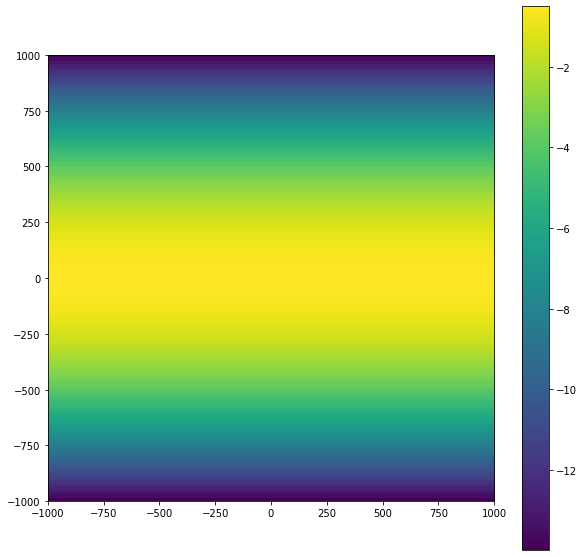

In [15]:
imshow(np.log10(u.rho),x=u.Lbox*0.5)

# Blast Wave in 2-D

Releasing a large amount of energy into a background fluid creates an explosion characterized by a strong shock wave, which then expands radially outwards from the point where the energy was released. In astrophysics, this happens, for example, in the case of supernovae. This is called a Sedov-Taylor blast wave. Sedov and Taylor first solved the problem in the context of atomic bomb explosions, but the solution is also useful in astrophysics. It can be used to test and validate hydrodynamical computer codes since an analytical solution exists. Blast waves are good candidates for adaptive mesh refinement (AMR) technique, that you read about in the book, but they can also be resolved with a uniform grid that we will use in the exam project. Add a function `blast_wave` that you can call in the time evolution loop. Use what you implemented in week 2, but update it to have a random position in $x$ and a position in $y$ that correlates with the disk height. Hint: a hydrostatic disk has a density profile which follows $\exp(-y^2/2H^2)$, this is a well known function for random variables. Remember that the box is periodic in the x-direction. Therefore a "radius function" for depositing energy and mass should also be periodic in that direction. If you integrate over your energy deposition profile and your mass profile (and remember to convert to physical units) you can aim for having 10 solar masses and $10^{44}$ J (or one foe) depositied in each explosion.